# Linear Curve Fitting (second example)

We will work with a second curve fitting example, starting with a simple linear regression on a computer generated dataset.

In [1]:
# Import the necessary libraries
import numpy as np
#%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
import scipy.stats as stats
from random import choices

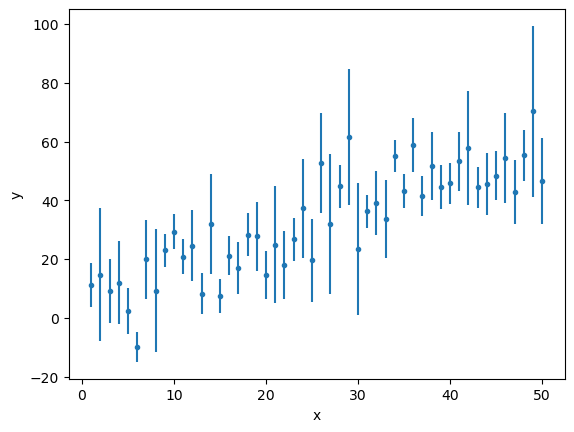

In [3]:
# Generating data points using the random function

n = 50 # number of points
x = np.arange(1, n+1) # independent variable

np.random.seed(45) # seed fixed to keep the same random selection of points
y = x + 10*np.random.randn(n) + 10 # dependent variable
yerr = np.abs(10*np.random.randn(n)) + 5 # error in y

# First look at the data
plt.figure()
plt.errorbar(x,y,yerr,marker='.',linestyle = 'None')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We will use a routine called `polyfit` from numpy to do the fitting. Some information about the `polyfit` function taken from its manual is presented below.

    polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)   
        Least squares polynomial fit.   
        
        Fit a polynomial ``p(x) = p[0] * x**deg + ... + p[deg]`` of degree `deg`   
        to points `(x, y)`. Returns a vector of coefficients `p` that minimises   
        the squared error.  
        
We will demonstrate how polyfit works in two ways:

- Fitting the data with a linear model without considering the uncertainty in $y$;
- Fitting the data with a linear model considering the uncertainty in $y$.

<b> Coefficient of Determination ($R^2$) <b>
    
A metric commonly used to quantify the proportion of the variation in the dependent variable that is predictable from the independent variable(s). That is defined as
    
\begin{equation}
    R^2 = 1 - \frac{SS_{res}}{SS_{tot}}
\end{equation}
      
- The sum of squares of residuals (residual sum of squares):
    
\begin{equation}
    SS_{res} = \sum_{i=1}^n \left (y_i - \hat{y}_i \right)^2
\end{equation}
    
- The total sum of squares (proportional to the variance of the data):
\begin{equation}
    SS_{tot} = \sum_{i=1}^n \left (y_i - \bar{y} \right)^2
\end{equation}
    
    
in which we have $n$ data points $(x_i, y_i),\: i=1, \dots , n$, with $x_i$ being the independent variable (or predictor) and $y_i$ being the dependent variable (or response) to be fitted by a linear model using <b>linear regression</b>. $\hat{y}$ is the best fit model with adjusted parameters $\{a_0,a_1\}$ for one predictor. $\bar{y}$ is the mean given by $(1/n)\sum_{i=1}^n y_i$.
    
$0\leq R^2 \leq 1$ with $R^2 = 1$ the ideal case with the model exactly matching the observed values ($SS_{res}=0$) and $R^2=0$ when the model always predicts $\bar{y}$.

In [7]:
p, cov = np.polyfit(x, y, 1, cov=True)  # coefficients and covariance matrix (but NO uncertainty in y)
# cov covariance matrix of the polynomial coefficient estimates. 
# The diagonal of cov contains the variance estimates for each coefficient. 

yhat = np.polyval(p, x)      # evaluate the linear model (polynomial of order 1) at x
ymean = np.mean(y)     # mean of y-data

perr = np.sqrt(np.diag(cov))       # standard-deviation estimates for each coefficient
resid = y - yhat # residuals
chi2red = np.sum((resid/yerr)**2)/(y.size - 2) # computing the chi2 reduced for the best fit

# In this case, R2 can be computed in two ways:
R2_cc = np.corrcoef(x, y)[0, 1]**2    # coefficient of determination taken from the correlation coefficient(x,y)
R2 = 1.0 - np.sum((y-yhat)**2)/np.sum((y-ymean)**2) # coefficient of determination from the definition
print("chi2red:", chi2red)
print("R2 =", R2_cc, R2)

chi2red: 1.2677999335819818
R2 = 0.7195904546084458 0.7195904546084462


<b> Interpretation </b>

The $R^2$ value indicates that approximately 72\% of the total data variance is explained by the best-fit regression model.

<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
C:\Users\cgroc\AppData\Local\Temp\ipykernel_13128\354692490.py:7: SyntaxWarning: invalid escape sequence '\p'
  plt.title('$y = %.2f \pm %.2f + (%.2f \pm %.2f)x \; [R^2=%.2f,\, \chi^2_{red}=%.1f]$'


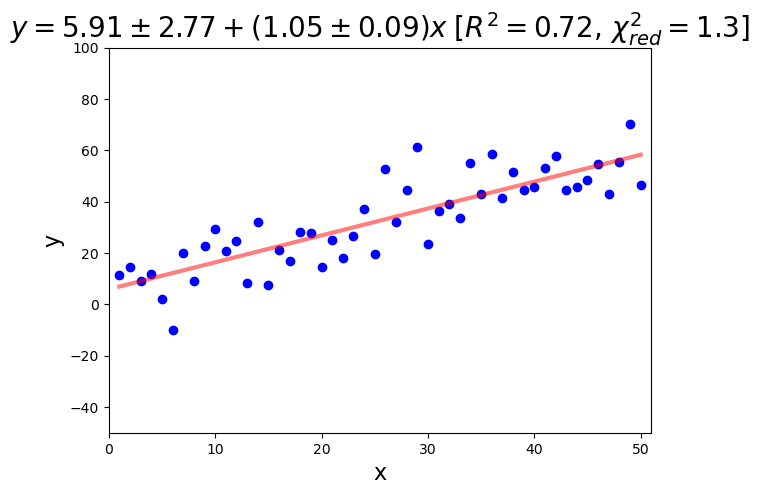

In [10]:
# plotting the data points with the model
plt.figure(figsize=(7, 5))
plt.plot(x, y, 'bo')
plt.plot(x, yhat, linewidth=3, color=[1, 0, 0, .5])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('$y = %.2f \pm %.2f + (%.2f \pm %.2f)x \; [R^2=%.2f,\, \chi^2_{red}=%.1f]$'
          %(p[1], perr[1], p[0], perr[0], R2, chi2red), fontsize=20, color=[0, 0, 0])
plt.xlim((0, n+1))
plt.ylim((-50, 100))
plt.show()

<b> Other linear regression visualization tools</b>

The `seaborn` library has a `regplot` function that can plot the data and a linear regression model fit directly. The plot will also show the confidence interval for the regression estimate. This will appear as translucent bands around the regression line. The confidence interval is estimated using a bootstrap which we will see later in the course. Note that `regplot` needs the data in `pandas dataframe` format. 

In [13]:
import pandas as pd
import seaborn as sns

# Creating pandas dataframe from numpy array
df = pd.DataFrame({'x': x, 'y': y, 'dy': yerr})

# See the first 5 rows of the dataframe
df.head()

,x,y,dy
0,1,11.263748,7.492960
1,2,14.603217,22.634922
2,3,9.048545,10.919594
3,4,11.956991,14.078117
4,5,2.283673,7.717996


<Axes: xlabel='x', ylabel='y'>

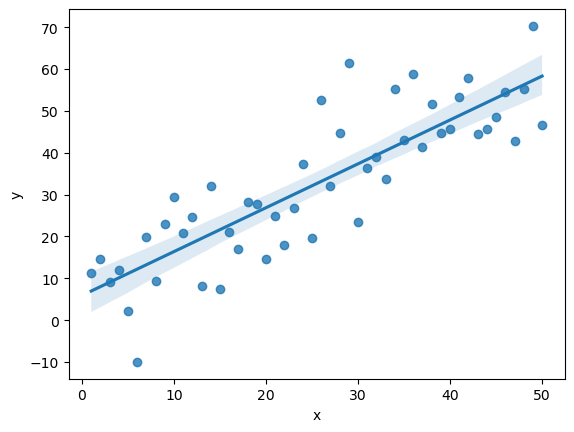

In [15]:
# Calling regplot
sns.regplot(data=df, x="x", y="y")
# The default of the confidence interval is ci = 95 (level of confidence) which corresponds to a 95% probability
# that the true linear regression line (of the population) will lie within the confidence interval of the regression model.

<b> Resampling </b>

- Jackknife Method
- Bootstrap Method (more general)

Uncertainty in the parameters can be derived through resampling methods.

In [17]:
## ==============================================
# jackknife (with pseudovalue approach) on the random generated data
N = y.size
aJackj=np.zeros(N)
bJackj=np.zeros(N)
aJackjStar=np.zeros(N)
bJackjStar=np.zeros(N)
xj=np.zeros((N,N-1)) # these are the resampled datasets, N sets of size N-1
yj=np.zeros((N,N-1))

# start with the estimates from the original data
bhat,ahat,r_value,p_value,std_err = stats.linregress(x,y)

for j in range(N):
    xj[j,:]=np.delete(x,j)
    yj[j,:]=np.delete(y,j)
    
    # these are the parameter estimates for jackknife set Zj
    bJackj[j],aJackj[j],r_value, p_value, std_err = stats.linregress(xj[j,:],yj[j,:])
    
    # pseudo-value estimation of the jth observation
    aJackjStar[j]=N*ahat-(N-1)*aJackj[j]
    bJackjStar[j]=N*bhat-(N-1)*bJackj[j]
    
# The jackknife estimators are obtained as the mean of the pseudovalues
meanaJackStar=np.mean(aJackjStar)
erraJackStar=np.std(aJackjStar,ddof=1)/N**0.5 # std of the pseudo-values in accordance with J. Tukey
meanbJackStar=np.mean(bJackjStar)
errbJackStar=np.std(bJackjStar,ddof=1)/N**0.5 # std of the pseudo-values in accordance with J. Tukey

print("Mean and std in the intercept (jackknife):", meanaJackStar, u"\u00B1", erraJackStar)
print("Mean and std in the slope (jackknife):", meanbJackStar, u"\u00B1", errbJackStar)

Mean and std in the intercept (jackknife): 5.948491997204046 ± 2.708930211102357
Mean and std in the slope (jackknife): 1.0460540447195676 ± 0.08901533376270686


In [21]:
def plotHist(a,b,nbins):
    fig, axs = plt.subplots(2,1, figsize=(6, 6), layout='constrained')
    
    intercept, bin_edges = np.histogram(a, bins=int(nbins))
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    norm0=len(a)*(bin_edges[-1]-bin_edges[0])/nbins
    
    axs[0].bar(bin_centers,intercept/norm0, width=0.5, label='intercept',color='b',edgecolor = 'black')
    axs[0].set_xlabel('intercept size', fontsize=15)
    axs[0].set_ylabel('Probability', fontsize=15)
    
    slope, bin_edges = np.histogram(b, bins=int(nbins))
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    norm0=len(b)*(bin_edges[-1]-bin_edges[0])/nbins
    
    axs[1].bar(bin_centers,slope/norm0, width=0.03, label='slope',color='r',edgecolor = 'black')
    axs[1].set_xlabel('slope size', fontsize=15)
    axs[1].set_ylabel('Probability', fontsize=15)
    
    plt.show()

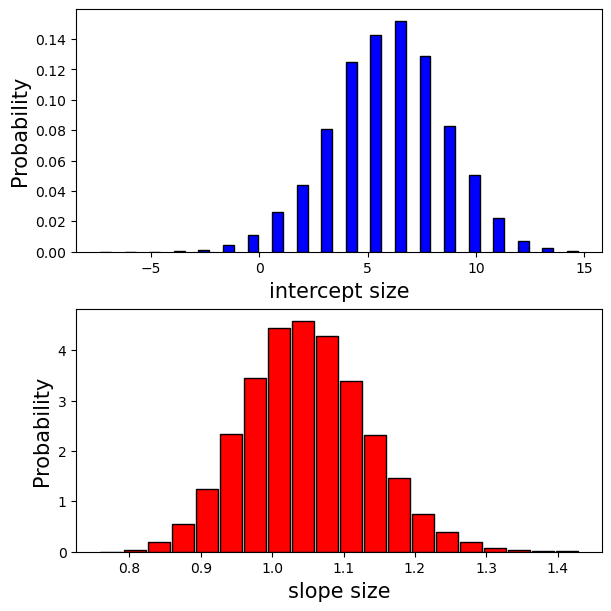

Bootstrap estimates (mean and std. dev.): a=5.899 +- 2.615, b=1.049 +- 0.085


<Figure size 640x480 with 0 Axes>

In [23]:
## ==============================================
# Bootstrap on the random generated data
NBoot=10000 # creating Nboot samples
aBoot=np.zeros(NBoot)
bBoot=np.zeros(NBoot)
indices=np.arange(N)

# Sorting many samples and performing linear regression
for i in range(NBoot):
    indicesChoice=choices(indices,k=N)
    bBoot[i],aBoot[i],r_value, p_value, std_err = stats.linregress(x[indicesChoice],y[indicesChoice])

# plot the distributions of parameters taken from bootstrap
plotHist(aBoot,bBoot,20)    

# Bootstrap estimates
aBootMean = np.mean(aBoot)
erraBoot = np.std(aBoot)
bBootMean = np.mean(bBoot)
errbBoot = np.std(bBoot)
print('Bootstrap estimates (mean and std. dev.): a=%3.3f +- %3.3f, b=%3.3f +- %3.3f'%(aBootMean,erraBoot,bBootMean,errbBoot))
plt.savefig('bootstrapresult.pdf')


<b>Curve fitting with uncertainty in $y$</b>

The next cell of code uses the same `polyfit` function but we will consider the uncertainty in $y$. In this way, a curve fitting method based on weighted least squares will be performed.

In [25]:
p_ebar, cov_ebar = np.polyfit(x, y, 1, w=1/yerr, cov=True)  # coefficients and covariance matrix (but WITH uncertainty in y)
yhat_ebar = np.polyval(p_ebar, x)          # evaluate the linear model (polynomial of order 1) at x

perr_ebar = np.sqrt(np.diag(cov_ebar))     # standard-deviation estimates for each coefficient
resid_ebar = y - yhat_ebar #residuals
chi2red_ebar = np.sum((resid_ebar/yerr)**2)/(y.size - 2) # computing the chi2 reduced for the best fit
print('chi2red =', chi2red)

R2_ebar = 1.0 - np.sum((y-yhat_ebar)**2)/np.sum((y-ymean)**2) # coefficient of determination taken from the definition
print("R2 =", R2_ebar)

chi2red = 1.2677999335819818
R2 = 0.7114889985031396


<b> Interpretation </b>

With the new model fitted considering the uncertainty in $y$, the $R^2$ value indicates that approximately 71\% of the total data variance is explained by the best-fit regression model. This means that the fitting quality with the uncertainty in $y$ does not differ significantly from the pure <b>linear regression</b>. However, note how different the intercept value is in comparison with the case without uncertainty.

<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
C:\Users\cgroc\AppData\Local\Temp\ipykernel_13128\3044404763.py:8: SyntaxWarning: invalid escape sequence '\p'
  plt.title('$y = %.2f \pm %.2f + (%.2f \pm %.2f)x \; [R^2=%.2f,\, \chi^2_{red}=%.1f]$'


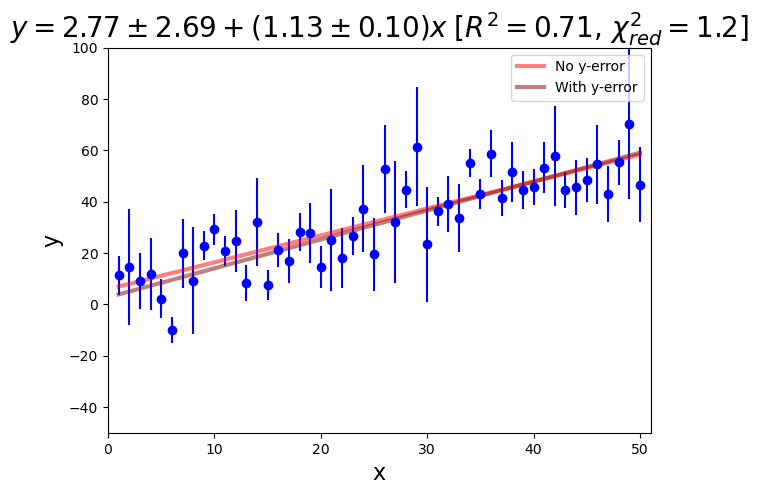

In [27]:
# plotting the result with both fittings
plt.figure(figsize=(7, 5))
plt.errorbar(x, y, yerr=yerr, fmt = 'bo', ecolor='b', capsize=0)
plt.plot(x, yhat, label="No y-error", linewidth=3, color=[1, 0, 0, .5])
plt.plot(x, yhat_ebar, label="With y-error", linewidth=3, color=[.5, 0, 0, .5])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('$y = %.2f \pm %.2f + (%.2f \pm %.2f)x \; [R^2=%.2f,\, \chi^2_{red}=%.1f]$'
          %(p_ebar[1], perr_ebar[1], p_ebar[0], perr_ebar[0], R2_ebar, chi2red_ebar), fontsize=20, color=[0, 0, 0])
plt.xlim((0, n+1))
plt.ylim((-50, 100))
plt.legend()
plt.show()

# Residual and Probability Plot Analysis

According to our assumptions, the residuals should be normally distributed. Let's create a function to plot the residuals and a normal probability plot that will be useful to check if the residuals are normally distributed. In particular, the normal probability plot is a graphical technique to identify substantive departures from normality. This is done by plotting the theoretical quantiles of a (reference) normal distribution versus the quantiles of the residual distribution in our case.

Source: [https://www.itl.nist.gov/div898/handbook/eda/section3/probplot.htm](https://www.itl.nist.gov/div898/handbook/eda/section3/probplot.htm ) 


The probability plot is a graphical technique for assessing whether or not a data set follows a given distribution, for instance, the normal distribution. 
The data are plotted against a theoretical distribution in such a way that the points should form approximately a straight line. Departures from this straight line indicate departures from the specified distribution

The normal probability plot is formed by:

-
Vertical axis: Ordered response value

-
Horizontal axis: Normal order statistic media.


The observations are plotted as a function of the corresponding normal order statistic medians which are defined as:

\begin{equation}
N_i = G(U_i)
\end{equation}
where $U_i$ are the uniform order statistic medians (defined with the equations below) and $G$ is the percent point function of the normal distribution. The percent point function is the inverse of the cumulative distribution function (probability that a value $x$ is less than or equal to some value). That is, given a probability, we can find the corresponding $x$ of the cumulative distribution functin. The uniform order statistic medians are defined as:.

\begin{gather*}
U_i &=& 1 - U_n \,\,\,\, \mbox{for} \,\,\,\, i=1 \\
U_i &=& (i - 0.3175)/(n + 0.365) \,\,\,\, \mbox{for} \,\,\,\, i = 2,3,..., n-1 \\
U_i &=& 0.5^{1/n} \,\,\,\, \mbox{for} \,\,\,\, i=n
\end{gather*}


with $n$ being the number of data points.


Reference: Filliben, J. J. (February 1975), The Probability Plot Correlation Coefficient Test for Normality, Technometrics, pp.111-117..

In [29]:
def plot_resid(x, resid):
    """ plot residuals and probability plot of residuals for a normal distribution."""

    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    ax[0].plot(x, resid, 'ro')
    ax[0].plot([0, x[-1]], [0, 0], 'k')
    ax[0].set_xlabel('x', fontsize=12)
    ax[0].set_ylabel('Residuals', fontsize=12)
    stats.probplot(resid, dist="norm", plot=plt)
    ax[1].set_xlabel('Normal theoretical quantiles', fontsize=12)
    ax[1].set_ylabel('Residual data quantiles', fontsize=12)
    ax[1].set_title('Normal Probability Plot of the residuals')

    plt.show()

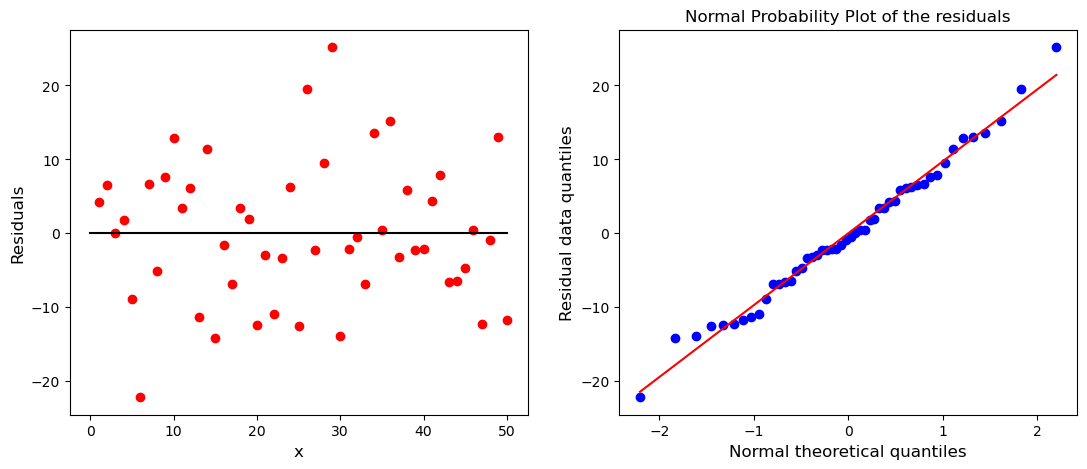

In [31]:
plot_resid(x, resid)

# Analysis of $\chi^2$ Surface

We will attempt to visualize $\chi^2$ surface in the parameter phase-space. For that, we will start a brand new fitting procedure of the data points using `lmfit`.

In [ ]:
from lmfit.models import LinearModel
from scipy import optimize as opt

# Linear regression with lmfit
model = LinearModel()
params = model.guess(y,x)

lm_result = model.fit(y, params, x=x, weights=1/yerr)
print(lm_result.fit_report())

plt.figure()
lm_result.plot()
plt.show()

In the cell below, we will optimize $\chi^2$ using `minimize` from `scipy.optimize` because we have flexibility to code $\chi^2$ manually, so we can use that to plot the $\chi^2$ surface in the parameter space.

In [ ]:
def linear_model(x, param):
    '''Linear model'''
    slope, intercept = param
    result = slope*x + intercept
    return result

def chi2(param, *args):
    '''Chi2 function'''
    slope, intercept = param
    x, y, yerr = args
    y_model = linear_model(x, (slope, intercept))
    residuals = (y_model - y)/yerr
    chi2 = np.sum( residuals**2 )
    return chi2

# initial guess of the parameters
guess = [2.2,3.4]
sol = opt.minimize(chi2, guess, args=(x, y, yerr))
print(sol)

print("slope =", sol.x[0],"intercept =", sol.x[1])


We will use the `meshgrid` technique to plot $\chi^2$ in a contour color plot as function of the slope and intercept parameters. The grid will be created around the minimum of $\chi^2$.

In [ ]:
#define the 2D phase space
p1 = np.linspace(sol.x[0]*0.8,sol.x[0]*1.2, 100) #grid in parameter 1
p2 = np.linspace(sol.x[1]*0.6,sol.x[1]*1.5, 100) #grid in parameter 2
P1, P2 = np.meshgrid(p1, p2) #2D grid

In [ ]:
# For z coordinate (with color), evaluate chi2 at each p1,p2 point in the grid.
Z = np.array([chi2([i,j],x,y,yerr) for (i,j) in zip(P1.ravel(), P2.ravel())]).reshape(P1.shape)

In [ ]:
# Plotting the surface with isolines
def plotColorsAndContours(X,Y,Z):
    fig, ax = plt.subplots(1, 1)
    c = ax.pcolor(X,Y,Z,cmap='RdBu')
    cb=fig.colorbar(c, ax=ax)
    plt.xlabel("b")
    plt.ylabel("a")
    cb.set_label("$\chi^{2}$")
    #Now let's plot the contours of Delta chi^2
    levels = [0.1,1,2.3,6.18,9, 16, 25, 36, 49, 64, 81, 100]
    for i0 in range(len(levels)):
        levels[i0] = levels[i0]+sol.fun
    c = plt.contour(X, Y, Z, levels,colors=['red', 'blue', 'yellow','green'])
    
    # This places an 'x' at the minimum
    plt.plot(sol.x[0],sol.x[1],'kx')
    #plt.show()

plotColorsAndContours(P1,P2,Z)

The question is: which one of those isolines correspond to a 1-$\sigma$ uncertainty? For that, we can use the definitions of probability density functions (PDF) and cumulative density functions (CDF) to apply Wilks' theorem.

In [ ]:
import scipy.stats as stats

# Given 1*sigma, we can obtain the area of a normal distribution within 1 standard deviation
sigma = 1
area_norm = stats.norm.cdf(sigma)-stats.norm.cdf(-sigma)
print("area normal =", area_norm)

mu = 0
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
plt.figure()
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.xlabel('values')
plt.ylabel('probability')
plt.grid()

# fill the area of the pdf between -sigma and +sigma around the zero mean
section = np.arange(-sigma, sigma+0.1, 0.1)
plt.fill_between(section,stats.norm.pdf(section, 0, sigma),facecolor='grey', alpha = 0.5)
plt.show()

In [ ]:
def pval(iVal):
    return stats.norm.cdf(iVal)-stats.norm.cdf(-iVal)

# The normal area is passed to a chi2 distribution of iNDOF degrees of freedom
def chi2Val(iGausSigma,iNDOF):
    val=stats.chi2.ppf(pval(iGausSigma),iNDOF)
    return val

# we can for instance calculate the value of chi^2 with 2 degrees of freedom and value = sigma
print("Chi2(value=sigma, DoF)=", chi2Val(1,2))

According to Wilks' theorem, from $\chi_{min}^2$, the difference $\Delta \chi^2 \approx 2.3$ will highlight the region of $\chi^2$ surface in which the parameters fluctuate within 1 standard deviation.

In [ ]:
# Set the degrees of freedom (df)
df = 2

# Generate data for the chi-squared distribution
x = np.linspace(0, 10, 1000)
y = stats.chi2.pdf(x, df)

# Calculate the value corresponding to 68.27% cumulative probability (approx. 2.296)
value_at_1_std_above_mean = chi2Val(1,2)
#value_at_1_std_above_mean = stats.chi2.ppf(0.6827, df)


# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(x, y, label=r'$\chi^2$ Distribution (df={})'.format(df))

# Fill the area below the value of 2.296 (68.27% cumulative probability)
x_fill = np.linspace(0, value_at_1_std_above_mean, 1000)
y_fill = stats.chi2.pdf(x_fill, df)
plt.fill_between(x_fill, y_fill, color='skyblue', alpha=0.5, label='Area for 68.27%')

# Add a vertical line at x = 2.296
plt.axvline(value_at_1_std_above_mean, color='red', linestyle='--', label=r'$\chi^2 = 2.296$')

# Add labels and title
plt.title(r'$\chi^2$ Distribution with 68.27% Area Marked (df={})'.format(df))
plt.xlabel(r'$\chi^2$')
plt.ylabel('Probability Density')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()